# Temporal Fusion Transformer 

https://towardsdatascience.com/temporal-fusion-transformer-time-series-forecasting-with-deep-learning-complete-tutorial-d32c1e51cd91

# Packages 

In [1]:
import numpy as np
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [39]:
import pandas as pd
import torch
import pytorch_lightning as pl
import pytorch_forecasting
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from torch import optim
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.metrics import QuantileLoss
from torch.utils.data import DataLoader, Dataset

# Data 

In [3]:
#!pip install pytorch-forecasting

Error downloading packages in regular envirenment, switched to new env 

In [4]:
# df = pd.read_csv('DataSets /carbonmonitor-global_datas_2023-07-21_WORLD_Sectors.csv', parse_dates=['date'], index_col='date')
df = pd.read_csv('DataSets /carbonmonitor-global_datas_2023-07-21_WORLD_Sectors.csv')

In [5]:
#df = df[['date', 'all_sectors', 'power']]

In [6]:
df

,date,power,industry,ground_transport,residential,domestic_aviation,international_aviation,all_sectors
0,2019-01-01,36.8332,25.4477,14.1566,18.38330,0.835247,1.48500,97.141047
1,2019-01-02,39.1125,26.9663,15.6887,18.79470,0.974611,1.62415,103.160961
2,2019-01-03,39.7868,27.2615,17.3509,18.55170,1.012280,1.66784,105.631020
3,2019-01-04,40.4257,28.0069,17.3865,18.39490,0.998781,1.68985,106.902631
4,2019-01-05,39.1776,27.0486,16.1779,17.62490,0.917965,1.73837,102.685335
...,...,...,...,...,...,...,...,...
1607,2023-05-27,34.9259,29.8055,18.1843,5.52400,0.931902,1.65229,91.023892
1608,2023-05-28,34.0203,29.1464,15.9872,5.37561,0.904233,1.62929,87.063033
1609,2023-05-29,35.5270,30.4091,16.1092,5.38921,0.965610,1.58654,89.986660
1610,2023-05-30,37.1301,31.7332,17.7775,5.39125,0.959809,1.55845,94.550309


# Preproccesing Data

In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
#df['date2'] = df['date'].copy()

In [9]:
df['date2'] = (df['date'] - df['date'].iloc[0]).dt.days

In [10]:
df.set_index('date', inplace=True)

In [11]:
#df['date2'] = pd.to_datetime(df['date2'])

In [12]:
df['group'] = 0

In [13]:
all_sectors_values = df['all_sectors'].values
power_values = df['power'].values

In [14]:
rows = 1612
batch_size = 220
seq_length = 7

num_batches = len(all_sectors_values) // (batch_size * seq_length)

num_samples_in_batches = num_batches * batch_size * seq_length

In [15]:
all_sectors_values = all_sectors_values[:num_samples_in_batches]
power_values = power_values[:num_samples_in_batches]

In [16]:
reshaped_all_sectors = all_sectors_values.reshape(num_batches, batch_size, seq_length)
reshaped_power = power_values.reshape(num_batches, batch_size, seq_length)

In [17]:
df

,power,industry,ground_transport,residential,domestic_aviation,international_aviation,all_sectors,date2,group
date,,,,,,,,,
2019-01-01,36.8332,25.4477,14.1566,18.38330,0.835247,1.48500,97.141047,0,0
2019-01-02,39.1125,26.9663,15.6887,18.79470,0.974611,1.62415,103.160961,1,0
2019-01-03,39.7868,27.2615,17.3509,18.55170,1.012280,1.66784,105.631020,2,0
2019-01-04,40.4257,28.0069,17.3865,18.39490,0.998781,1.68985,106.902631,3,0
2019-01-05,39.1776,27.0486,16.1779,17.62490,0.917965,1.73837,102.685335,4,0
...,...,...,...,...,...,...,...,...,...
2023-05-27,34.9259,29.8055,18.1843,5.52400,0.931902,1.65229,91.023892,1607,0
2023-05-28,34.0203,29.1464,15.9872,5.37561,0.904233,1.62929,87.063033,1608,0
2023-05-29,35.5270,30.4091,16.1092,5.38921,0.965610,1.58654,89.986660,1609,0


# TimeSeries DataSet 

In [18]:

# create the time-series dataset from the pandas df
dataset = TimeSeriesDataSet(
    df,
    group_ids=["group"],
    target="all_sectors",
    time_idx="date2",
    max_encoder_length=7,
    max_prediction_length=1,
    time_varying_unknown_reals=["all_sectors"],
    target_normalizer=None
)

# Passing Timeseries to our dataloader 

In [19]:
dataloader = dataset.to_dataloader(batch_size=1)

x, y = next(iter(dataloader))
print(x['encoder_target'])
print(x['groups'])
print('\n')
print(x['decoder_target'])

tensor([[93.4063, 89.5200, 86.2897, 92.6024, 92.1199, 91.2502, 91.7306]])
tensor([[0]])


tensor([[93.5922]])


# Preparing dataset for TimeSeries format 

In [20]:
# df['date'] = pd.to_datetime(df['date'])

#df.set_index('date2', inplace=True)

In [21]:
start_date = df.index.min()

In [22]:
df_list = []

for label in df:

    ts = df[label]

    start_date = min(ts.index)
    end_date = max(ts.index)

    active_range = (ts.index >= start_date) & (ts.index <= end_date)

    tmp = pd.DataFrame({'all_sectors': ts})
    date = tmp.index

    tmp['days_from_start'] = (date - start_date).days
    tmp['date'] = date
    tmp['day'] = date.day
    tmp['day_of_week'] = date.dayofweek
    tmp['month'] = date.month
    tmp['group'] = 0
    df_list.append(tmp)

time_df = pd.concat(df_list).reset_index(drop=True)

In [23]:
time_df.head()

,all_sectors,days_from_start,date,day,day_of_week,month,group
0,36.8332,0,2019-01-01,1,1,1,0
1,39.1125,1,2019-01-02,2,2,1,0
2,39.7868,2,2019-01-03,3,3,1,0
3,40.4257,3,2019-01-04,4,4,1,0
4,39.1776,4,2019-01-05,5,5,1,0


# HyperParams

In [24]:
# Hyperparameters 

batch_size = 64
heads = 4
hidden_size = 160
lr = 0.001
gr_clip = 0.1

# Turning our dataframe into a TimeseriesDataset 

In [25]:
max_encoder_length = 7
max_prediction_length = 1
training_cutoff = time_df['days_from_start'].max() - max_prediction_length

training = TimeSeriesDataSet(
    time_df[lambda x: x.days_from_start <= training_cutoff],  # Defining training part 
    time_idx = 'days_from_start',
    target = 'all_sectors',
    group_ids = ['group'],
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    allow_missing_timesteps=True,
    time_varying_known_reals=["days_from_start","day","day_of_week", "month"],  
     # normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

# Passing our TimeSeries data to our dataloader 

# if you have a strong GPU, feel free to increase the number of workers  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# Creating a BaseLine Model

In [26]:
import os 
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
import torch.nn as nn
import torch.cuda as cuda 
from pytorch_forecasting.models import Baseline

Checking if cuda is available 

In [27]:
if cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Moving our model and data to the GPU

In [28]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).to(device)
baseline_predictions = Baseline().predict(val_dataloader)
baseline_predictions = baseline_predictions.to(device)

In [29]:
MAE = (actuals - baseline_predictions).abs().mean().item()
MAE

37.832298278808594

In [30]:

#average p50 loss overall
print((actuals - baseline_predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - baseline_predictions).abs().mean(axis=1))


37.832298278808594
tensor([37.8323])


In [31]:
raw_preds = Baseline().predict(val_dataloader, mode='raw', return_x=True)
print(raw_preds._fields)

('output', 'x', 'index', 'decoder_lengths', 'y')


In [32]:
print(raw_preds.output._fields)

('prediction',)


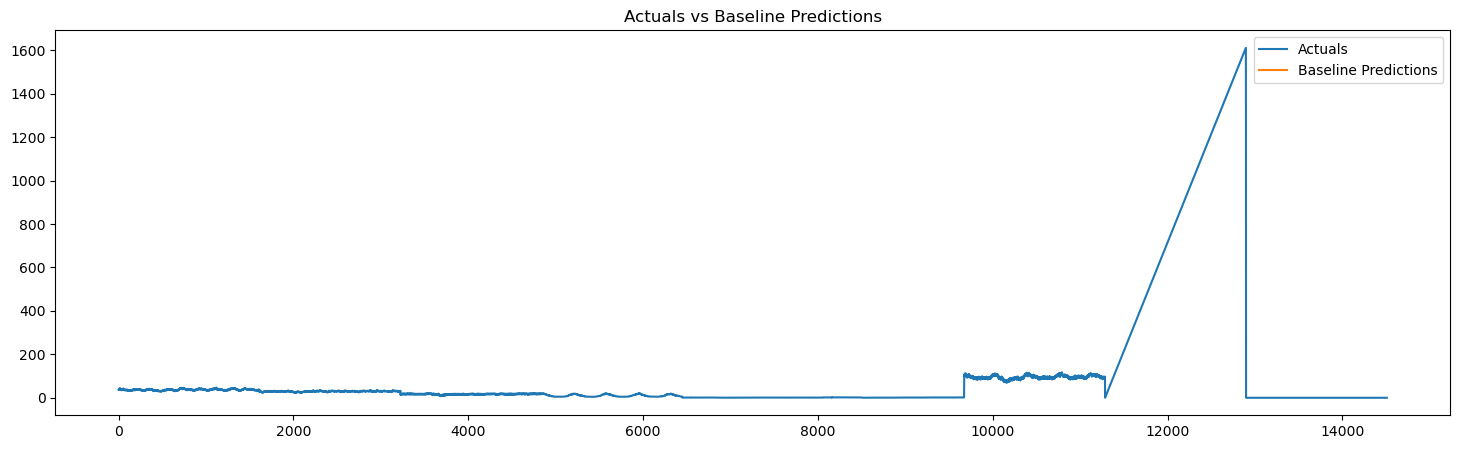

In [59]:
import matplotlib.pyplot as plt

# Convert the actuals and baseline predictions to numpy arrays
actuals = actuals.cpu().numpy()
baseline_predictions = baseline_predictions.cpu().numpy()

# Assuming 'time_df' is a DataFrame with a column named 'all_sectors'
ts = time_df['all_sectors'].values  # Convert the pandas Series to a numpy array

plt.figure(figsize=(18, 5))
plt.plot(ts, label="Actuals")
plt.plot(baseline_predictions, label="Baseline Predictions")

plt.title("Actuals vs Baseline Predictions")
plt.legend()
plt.show()

In [52]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(8, 6))
#plt.bar(['Absolute Mean Error'], [MAE], color='blue')
#plt.xlabel('Metric')
#plt.ylabel('Value')
#plt.title('Absolute Mean Error between Actuals and Baseline Predictions')
#plt.show()

# Building and training our model 

In [34]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
import warnings
import torch.optim as optim
warnings.filterwarnings("ignore", category=UserWarning)

In [35]:
# device = torch.device("cpu")

In [ ]:
class TFTModel(TemporalFusionTransformer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

# Creëer een instantie van het model
model = TFTModel.from_dataset(
    training,
    learning_rate=0.1,  # Leer snelheid (kan worden aangepast)
    hidden_size=16,  # Grootte van verborgen lagen (kan worden aangepast)
    attention_head_size=1,  # Grootte van aandachtslagen (kan worden aangepast)
    dropout=0.1,  # Dropout-rate (kan worden aangepast)
    loss=pytorch_forecasting.metrics.QuantileLoss(),  # Verliesfunctie
    log_interval=10,  # Interval voor het loggen van training
    reduce_on_plateau_patience=4,  # Patience voor ReduceLROnPlateau
)

# Optioneel: model samenvatting weergeven
print(model)


In [51]:
# Definieer de trainer
trainer = pl.Trainer(
    max_epochs=50,  # Aantal trainingsepochen 
)

# Train het model
trainer.fit(model, train_dataloader=train_dataloader)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TypeError: fit() got an unexpected keyword argument 'train_dataloader'

In [45]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs")  

model = TFTModel

trainer = pl.Trainer(
    max_epochs=45,
    accelerator='cpu',
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger
)

trainer.fit(
    model,
    train_dataloader,
    val_dataloader
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `type`

# Passing our TimeSeries dataset to our Dataloader 